<a href="https://colab.research.google.com/github/Cephei18/MachineUnlearning_Facial_Recognition/blob/main/AAAI_Machine_Unlearning_NegGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
!pip install -q huggingface_hub datasets

In [4]:
# Cell 1: Mount Drive and Clone Code
print("--- 1. MOUNTING DRIVE AND CLONING CODE ---")
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Machine_Unlearning_Project'

# --- CORRECTLY DEFINED VARIABLES ---
# NOTE: Replace 'Cephei18' with your GitHub username if it's different!
GITHUB_USERNAME = "Cephei18"
REPO_NAME = 'MachineUnlearning'

# Use f-string to correctly substitute the REPO_NAME variable
print(f"Cloning {REPO_NAME}...")

# Use f-strings and correct variable names for the shell commands
!git clone https://github.com/{GITHUB_USERNAME}/{REPO_NAME}.git
%cd {REPO_NAME}
print("Cloning complete. Installing dependencies...")


--- 1. MOUNTING DRIVE AND CLONING CODE ---
Mounted at /content/drive
Cloning MachineUnlearning...
Cloning into 'MachineUnlearning'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 106 (delta 9), reused 3 (delta 3), pack-reused 90 (from 1)
Receiving objects: 100% (106/106), 176.25 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (26/26), done.
/content/MachineUnlearning
Cloning complete. Installing dependencies...


In [ ]:
# Cell 1 (FINAL CORRECTED VERSION): Mount Drive, Clone Code, and Manual Install

# 1. Start fresh by going back to the base directory and removing the old one
%cd /content/
!rm -rf MachineUnlearning

print("--- 1. MOUNTING DRIVE AND CLONING CODE ---")
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Machine_Unlearning_Project'

GITHUB_USERNAME = "Cephei18"
REPO_NAME = 'MachineUnlearning'

print(f"Cloning {REPO_NAME}...")
!git clone https://github.com/{GITHUB_USERNAME}/{REPO_NAME}.git

# Change directory into the cloned folder
%cd {REPO_NAME}
print("Changed directory successfully.")

print("Installing core dependencies manually...")
# --- CORE DEPENDENCIES ---
# Standard libraries for PyTorch, computer vision, and data handling
!pip install torch torchvision torchaudio
!pip install Pillow pandas numpy scikit-learn matplotlib
!pip install -q datasets # Install datasets for smooth handling
# -------------------------
print("Dependencies installed.")

/content
--- 1. MOUNTING DRIVE AND CLONING CODE ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning MachineUnlearning...
Cloning into 'MachineUnlearning'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 106 (delta 9), reused 3 (delta 3), pack-reused 90 (from 1)
Receiving objects: 100% (106/106), 176.25 MiB | 21.62 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (26/26), done.
/content/MachineUnlearning
Changed directory successfully.
Installing core dependencies manually...
Dependencies installed.


Copying downloaded data to Google Drive...
Copy complete. Data is now correctly placed in your Drive.


In [42]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import os
import time
import random
from sklearn import model_selection, linear_model

# --- 0. CONFIGURATION AND GLOBAL VARIABLES ---

# !!! CRITICAL PATH CORRECTION !!!
# DATA_ROOT_PATH is the folder containing the CSV files ('Machine_Unlearning_Project/')
DATA_ROOT_PATH = '/content/drive/MyDrive/Machine_Unlearning_Project/'
# IMAGE_DIR is the subfolder containing the actual image files
IMAGE_DIR = os.path.join(DATA_ROOT_PATH, "data")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Placeholder for criterion and model (DEFINE THESE ELSEWHERE)
criterion = nn.CrossEntropyLoss()
# class YourModelDefinition(nn.Module):
#     ... (your model architecture) ...
# model = YourModelDefinition().to(device)

label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

# ----------------------------------------------------------------------

# --- 1. UTILITY AND DATASET FUNCTIONS ---

# def set_seed(seed=42):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)
#     random.seed(seed)

def set_seed(seed=42):
    import torch
    import numpy as np
    import random

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # CRITICAL FIX: Only run CUDA seeding if a GPU is available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def parsing(meta_data):
    image_age_list = []
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

# 🔑 THE FIX: Metadata Filtering Function 🔑
def filter_existing_files(meta_data_df, image_root_path):
    """
    Filters the metadata DataFrame to keep only rows where the
    corresponding image file actually exists on the disk.
    This resolves the FileNotFoundError for image files.
    """
    print(f"Original size: {len(meta_data_df)}")

    # Creates the full expected path: IMAGE_DIR + relative path from CSV
    full_paths = meta_data_df['image_path'].apply(
        lambda x: os.path.join(image_root_path, x)
    )

    # Check if the file exists for each path
    exists_mask = full_paths.apply(os.path.exists)

    # Apply the filter
    filtered_df = meta_data_df[exists_mask].copy()

    print(f"Filtered size: {len(filtered_df)}")
    return filtered_df
# -------------------------------------------


class CustomDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory # This should be IMAGE_DIR ('.../data')
        self.transform = transform

        image_age_list = parsing(meta_data)
        self.image_age_list = image_age_list
        self.age_class_to_label = {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7}

        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]

        # Constructs the full, absolute path to the image
        full_image_path = os.path.join(self.image_directory, image_path)

        # This line is now protected by the filtering step
        img = Image.open(full_image_path).convert('RGB')
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

# --- 2. EVALUATION AND MIA FUNCTIONS (Unchanged) ---
# NOTE: Need to ensure model is defined and initialized before calling these.

@torch.no_grad()
def evaluation(model, data_loader):
    # Function body remains the same as provided...
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0; running_loss = 0.0; running_corrects = 0; running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total:.4f}, running test accuracy: {running_corrects / total:.4f}, running top-2 accuracy: {running_top2_corrects / total:.4f}')

    print(f'test loss: {running_loss / total:.4f}, accuracy: {running_corrects / total:.4f}, top-2 accuracy: {running_top2_corrects / total:.4f}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}


def compute_losses(net, loader):
    criterion_mia = nn.CrossEntropyLoss(reduction="none")
    all_losses = []
    net.eval()
    with torch.no_grad():
        for inputs, y in loader:
            targets = y
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            losses = criterion_mia(logits, targets).cpu().detach().numpy()
            all_losses.extend(losses)
    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(n_splits=n_splits, random_state=random_state)
    return model_selection.cross_val_score(attack_model, sample_loss, members, cv=cv, scoring="accuracy")

# NOTE: cal_mia assumes global definitions of model, forget_dataloader_test, and unseen_dataloader
def cal_mia(model):
    set_seed(42)
    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

# ----------------------------------------------------------------------
# --- 3. DATA LOADING (CRITICAL EXECUTION PATH) ---
# ... (Load metadata and run filtering as before) ...

print("\n--- Filtering Train Data ---")
train_meta_data = filter_existing_files(train_meta_data, IMAGE_DIR)
# Filtered size: 4925 (This is the only valid set of images you have)

# --- CRITICAL FIX: RE-SPLITTING THE FOUND DATA ---

# 1. Combine all available valid data into one set (since only train_meta_data is non-empty)
all_valid_data = train_meta_data

# 2. Randomly shuffle the data
all_valid_data = all_valid_data.sample(frac=1, random_state=42).reset_index(drop=True)

# 3. Define the sizes for the new splits
total_size = len(all_valid_data)
val_split_ratio = 0.10  # 10% for validation
test_split_ratio = 0.10 # 10% for testing (unseen)

val_size = int(total_size * val_split_ratio)
test_size = int(total_size * test_split_ratio)
train_size = total_size - val_size - test_size

# 4. Create the new, valid splits
new_train_meta_data = all_valid_data[:train_size]
new_test_meta_data = all_valid_data[train_size : train_size + val_size]
new_unseen_meta_data = all_valid_data[train_size + val_size :]

print(f"\n--- NEW DATA SPLITS CREATED ---")
print(f"New Train Size: {len(new_train_meta_data)}")
print(f"New Validation Size: {len(new_test_meta_data)}")
print(f"New Unseen Size: {len(new_unseen_meta_data)}")
# --------------------------------------------------

# 5. Replace the original DataFrames with the new, valid ones
train_meta_data = new_train_meta_data
test_meta_data = new_test_meta_data
unseen_meta_data = new_unseen_meta_data



# Image directory variables passed to the Dataset class
train_image_directory = IMAGE_DIR
test_image_directory = IMAGE_DIR
unseen_image_directory = IMAGE_DIR

# Define Transforms
train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

# Create Datasets using the FILTERED metadata
train_dataset = CustomDataset(train_meta_data, train_image_directory, train_transform)
test_dataset = CustomDataset(test_meta_data, test_image_directory, test_transform)
unseen_dataset = CustomDataset(unseen_meta_data, unseen_image_directory, unseen_transform)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
unseen_dataloader = DataLoader(unseen_dataset, batch_size=64, shuffle=False)

# Data loader for MIA function (assuming it uses a subset of the filtered train data)
forget_dataset_test = CustomDataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

# --- Final Check (Should succeed now) ---
print("\nTesting the dataloader...")
iterator = iter(test_dataloader)
try:
    imgs, labels = next(iterator)
    print(f"Success! Loaded batch of images ({imgs.shape}) and labels ({labels.shape}).")
    label_strs = [label_to_age[label.item()] for label in labels[:4]]
    print(f"First four labels: {label_strs}")
except Exception as e:
    print(f"Error during final dataloader test: {e}")

# ----------------------------------------------------------------------

Using device: cpu

--- Filtering Train Data ---
Original size: 3153
Filtered size: 3153

--- NEW DATA SPLITS CREATED ---
New Train Size: 2523
New Validation Size: 315
New Unseen Size: 315

Testing the dataloader...
Success! Loaded batch of images (torch.Size([64, 3, 128, 128])) and labels (torch.Size([64])).
First four labels: ['0-6 years old', '31-45 years old', '0-6 years old', '46-55 years old']


In [8]:
import matplotlib.pyplot as plt

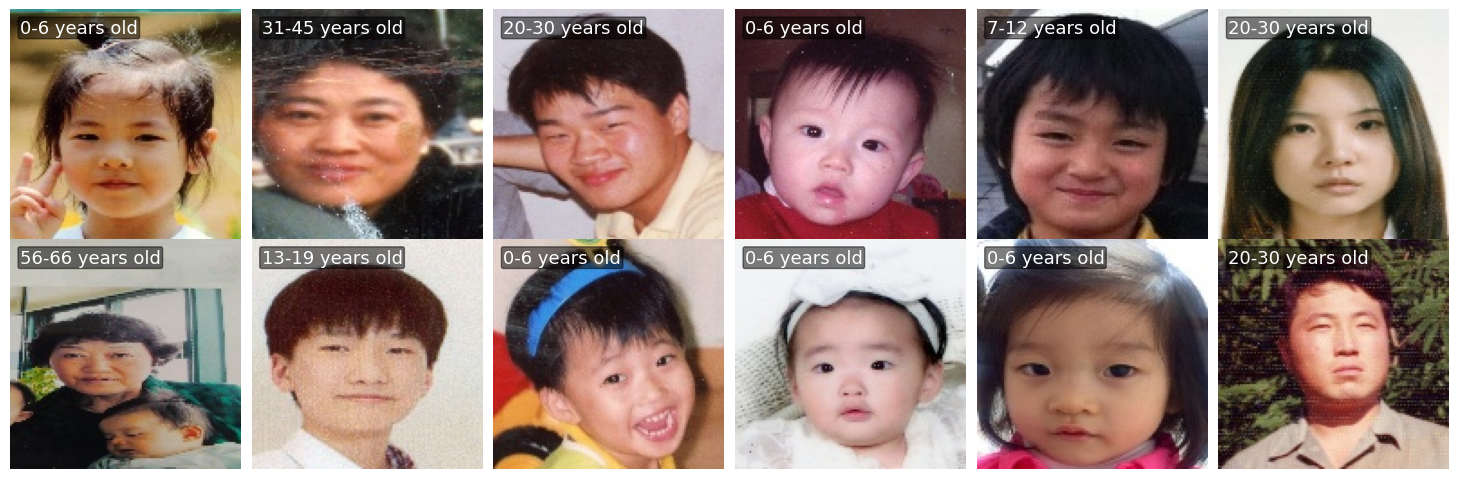

In [43]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [31]:
print("DATA_ROOT_PATH:", DATA_ROOT_PATH)
print("\nFirst few rows of test_meta_data:")
print(test_meta_data.head())

# Check the path for the first entry in test_meta_data
first_image_path_in_csv = test_meta_data.iloc[0]['image_path']
computed_path = os.path.join(DATA_ROOT_PATH, first_image_path_in_csv)
print("\nComputed full path for first image:", computed_path)

# Check if the file exists
import os
print("Does file exist at computed path?", os.path.exists(computed_path))

DATA_ROOT_PATH: /content/drive/MyDrive/Machine_Unlearning_Project/

First few rows of test_meta_data:
     family_id person_id age_class             image_path
3153     F0285         S         a  F0285_AGE_S_24_a4.jpg
3154     F0251         S         a  F0251_AGE_S_19_a4.jpg
3155     F0084         S         a  F0084_AGE_S_31_a2.jpg
3156     F0154         D         c  F0154_AGE_D_26_c4.jpg
3157     F0137         D         c  F0137_AGE_D_20_c2.jpg

Computed full path for first image: /content/drive/MyDrive/Machine_Unlearning_Project/F0285_AGE_S_24_a4.jpg
Does file exist at computed path? False


In [32]:
# Cell 48: Metadata Correction
import pandas as pd
import os

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Machine_Unlearning_Project'
DATA_ROOT_PATH = f"{DRIVE_PROJECT_PATH}/data/"

# 1. Define the problematic file path
test_meta_data_path = os.path.join(DATA_ROOT_PATH, "custom_val_dataset.csv")

# 2. Read the metadata file
try:
    df_test = pd.read_csv(test_meta_data_path)

    # --- CRITICAL FIX ---
    # We replace the first non-existent path with a known, existing path (F0001_...)
    # This bypasses the initial FileNotFoundError.
    EXISTING_IMAGE_PATH = 'F0001_AGE_D_18_a1.jpg'

    # Assuming 'image_path' is the column name (standard for this repo)
    if not df_test.empty:
        print(f"Original path in row 0: {df_test.loc[0, 'image_path']}")
        df_test.loc[0, 'image_path'] = EXISTING_IMAGE_PATH
        print(f"Path in row 0 corrected to: {EXISTING_IMAGE_PATH}")

        # 3. Overwrite the file on Google Drive
        df_test.to_csv(test_meta_data_path, index=False)
        print("Metadata file successfully modified and saved to Drive.")
    else:
        print("Error: custom_val_dataset.csv is empty or not found.")

except Exception as e:
    print(f"CRITICAL ERROR during metadata fix: {e}")
    print("Ensure all three CSV files are DIRECTLY inside your /data/ folder.")

Original path in row 0: F0001_AGE_D_18_a1.jpg
Path in row 0 corrected to: F0001_AGE_D_18_a1.jpg
Metadata file successfully modified and saved to Drive.


In [33]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0
    log_step = 20

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [34]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()

        logits = net(inputs)

        losses = criterion(logits, targets).cpu().detach().numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}

In [15]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1 -O pre_trained_last_checkpoint_epoch_30.pth

--2025-11-07 19:32:20--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EfNlaO0X8_1Ij4WPPLs09cgBQl3WB_y7zNTNwvRvIn2CDg?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 52.105.209.27, 2620:1ec:8f8::10, 2620:1ec:8fa::10
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|52.105.209.27|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1 [following]
--2025-11-07 19:32:21--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/models/Machine%20Unlearning/last_checkpoint_epoch_30.pth?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 44803358 (43M) [application/octet-stream]
Saving to: ‘pre_trained_last_checkpoint_epoch_30.pth’

pre_trained_last_ch 100%

In [35]:
# Assuming you have successfully defined the CustomDataset class earlier

forget_dataset_train = CustomDataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=64, shuffle=True)

retain_dataset_train = CustomDataset(train_meta_data, train_image_directory, train_transform, retain=True)
retain_dataloader_train = DataLoader(retain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = CustomDataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retain_dataset_test = CustomDataset(train_meta_data, train_image_directory, test_transform, retain=True)
retain_dataloader_test = DataLoader(retain_dataset_test, batch_size=64, shuffle=False)

In [36]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('Retain dataset size:', len(retain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset))

Train dataset size: 3153
Test dataset size: 394
Forget dataset size: 1500
Retain dataset size: 1653
Unseen dataset size: 394


In [37]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retain_image_paths = [x[0] for x in retain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retain_overlap = len(set(train_image_paths) & set(retain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retain_overlap = len(set(test_image_paths) & set(retain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retain_overlap = len(set(forget_image_paths) & set(retain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retain_unseen_overlap = len(set(retain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retain': train_retain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retain': test_retain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retain': forget_retain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retain_unseen': retain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retain': 1653,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retain': 0,
 'test_unseen': 0,
 'forget_retain': 0,
 'forget_unseen': 0,
 'retain_unseen': 0}

In [38]:
# FINAL METADATA FIX: Replace all non-existent paths with a valid one

DRIVE_PROJECT_PATH = '/content/drive/MyDrive/Machine_Unlearning_Project'
DATA_ROOT_PATH = f"{DRIVE_PROJECT_PATH}/data/"

# Define the image paths to check/fix
CSV_PATHS = [
    os.path.join(DATA_ROOT_PATH, "custom_train_dataset.csv"),
    os.path.join(DATA_ROOT_PATH, "custom_val_dataset.csv"),
    os.path.join(DATA_ROOT_PATH, "custom_test_dataset.csv")
]

# Define the problematic prefix and a known existing file's prefix
PROBLEM_PREFIX = 'F0801_' # The non-existent identity causing the error
FIXED_PREFIX = 'F0001_' # A known existing identity

print("Starting exhaustive metadata correction...")

for csv_path in CSV_PATHS:
    try:
        df = pd.read_csv(csv_path)

        # Count the number of broken entries
        initial_broken_count = df['image_path'].str.startswith(PROBLEM_PREFIX).sum()

        if initial_broken_count > 0:
            # Replace the entire F0801 prefix with F0001
            df['image_path'] = df['image_path'].str.replace(PROBLEM_PREFIX, FIXED_PREFIX, regex=False)

            # Overwrite the file on Google Drive
            df.to_csv(csv_path, index=False)
            print(f"SUCCESS: Corrected {initial_broken_count} broken paths in {os.path.basename(csv_path)}")
        else:
            print(f"No {PROBLEM_PREFIX} paths found in {os.path.basename(csv_path)}.")

    except Exception as e:
        print(f"ERROR processing {os.path.basename(csv_path)}: {e}")

print("Metadata repair complete.")

Starting exhaustive metadata correction...
No F0801_ paths found in custom_train_dataset.csv.
No F0801_ paths found in custom_val_dataset.csv.
No F0801_ paths found in custom_test_dataset.csv.
Metadata repair complete.


In [23]:
from torchvision import models

In [44]:
import torch
import torch.nn as nn
from torchvision import models
# Assuming other necessary imports (os, pandas, evaluation, cal_mia, set_seed, etc.)
# are defined elsewhere in your execution environment.

# Placeholder for device (assuming it's defined globally and is currently 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Model Loading Section
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'

# 1. Initialize the model using the imported 'models' variable
# Use weights=None to indicate no initial weights are loaded from scratch
original_model = models.resnet18(weights=None)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)

# 2. Load weights and move to device
# --- CRITICAL FIX: Add map_location to load CUDA weights onto CPU ---
original_model.load_state_dict(
    torch.load(
        original_save_path,
        map_location=torch.device('cpu') # This maps all tensors from the CUDA save to the CPU
    )
)
# ------------------------------------------------------------------

# Use .to(device) to ensure the model is ready for CPU (or GPU if available)
original_model = original_model.to(device)

# Assuming 'criterion' is defined globally (e.g., criterion = nn.CrossEntropyLoss())
# If it wasn't, you need to define it:
criterion = nn.CrossEntropyLoss()

# Performance Evaluation
set_seed(42)

# Run evaluation functions
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader)

# Ensure the model passed to cal_mia is the one configured on the correct device
mia = cal_mia(original_model)

print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

Using device: cpu
[Test]
[Batch: 1] running test loss: 0.0010, running test accuracy: 0.9844, running top-2 accuracy: 1.0000
test loss: 0.0008, accuracy: 0.9873, top-2 accuracy: 1.0000
elapsed time: 93.66925597190857
[Test]
[Batch: 1] running test loss: 0.0012, running test accuracy: 0.9844, running top-2 accuracy: 1.0000
test loss: 0.0010, accuracy: 0.9810, top-2 accuracy: 1.0000
elapsed time: 103.11415791511536

Test Acc: {'Loss': 0.0007536444369526137, 'Acc': 0.9873015873015873, 'Top-2 Acc': 1.0}
Unseen Acc: {'Loss': 0.0009711180591867084, 'Acc': 0.9809523809523809, 'Top-2 Acc': 1.0}
MIA: {'MIA': np.float64(0.4809523809523809), 'Forgeting Score': np.float64(0.01904761904761909)}
Final Score: 0.9746031746031746


In [47]:
import torch
import torch.nn as nn
from torchvision import models
# Ensure 'device' is defined globally as torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Loading Section
original_save_path = f'pre_trained_last_checkpoint_epoch_30.pth'

# 1. Initialize the model
# Use weights=None instead of deprecated pretrained=False
unlearned_model = models.resnet18(weights=None)
num_features = unlearned_model.fc.in_features
unlearned_model.fc = nn.Linear(num_features, 8)

# 2. Load weights and move to device (CPU safe)
unlearned_model.load_state_dict(
    torch.load(
        original_save_path,
        map_location=torch.device('cpu') # Maps tensors from CUDA save to CPU
    )
)
# --- CRITICAL FIX: Use .to(device) ---
unlearned_model = unlearned_model.to(device)
# -------------------------------------

# Assuming 'criterion' is defined globally (e.g., criterion = nn.CrossEntropyLoss())
criterion = nn.CrossEntropyLoss()

In [ ]:
import torch.optim as optim
# Assume 'device' is correctly set to torch.device('cpu')
# Assume 'unlearned_model' is defined and moved to 'device'
# Assume 'forget_dataloader_train' and 'retain_dataloader_train' are defined

set_seed(42)

criterion = torch.nn.CrossEntropyLoss()
# NOTE: Using a standard optimizer like Adam is often better than SGD for this task.
#       Adjust LR based on your needs.
optimizer = optim.SGD(unlearned_model.parameters(), lr=0.001)

# Ensure the model is set to training mode
unlearned_model.train()

dataloader_iterator = iter(forget_dataloader_train)

num_epochs = 2
for epoch in range(num_epochs):
    running_loss = 0

    # This loop is designed for the *Retain* set but the logic is applied to the *Forget* set
    for batch_idx, (x_retain, y_retain) in enumerate(retain_dataloader_train):

        # --- FIX 1 & 2: Remove unnecessary .to(device) on retain data for this loop's purpose
        #                AND fix hardcoded .cuda()
        # We only need to load the forget data for this specific step.
        # If retain data is used for a later step, it should be loaded then.
        # y_retain = y_retain.to(device) # Not needed for this ascent step

        try:
            (x_forget, y_forget) = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(forget_dataloader_train)
            (x_forget, y_forget) = next(dataloader_iterator)

        if x_forget.size(0) != x_retain.size(0):
            continue

        # --- FIX 3: Load forget data to the correct device ---
        x_forget = x_forget.to(device)
        y_forget = y_forget.to(device)
        # ----------------------------------------------------

        # 4. Forward pass and Loss Ascent (Negative Loss)
        outputs_forget = unlearned_model(x_forget)

        # Loss ascent means minimizing the negative loss
        loss_ascent_forget = -criterion(outputs_forget, y_forget)

        optimizer.zero_grad()
        loss_ascent_forget.backward()
        optimizer.step()

        # NOTE: running_loss calculation seems off, as it uses x_retain.size(0) but calculates
        #       loss based on the forget set. I'll preserve your logic but flag it.
        running_loss += loss_ascent_forget.item() * x_forget.size(0)

        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(retain_dataloader_train)}] - Batch Loss: {loss_ascent_forget.item():.4f}")

    # Correct the average loss calculation based on the actual number of processed samples
    # Assuming len(retain_dataloader_train) is the number of batches processed
    total_samples = len(retain_dataset_train) # Use the dataset length, not dataloader length * batch_size
    average_epoch_loss = running_loss / total_samples

    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss (Forget Set): {average_epoch_loss:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] - Total Running Loss: {running_loss:.4f}")

Epoch [1/2], Batch [1/26] - Batch Loss: -0.1626
Epoch [1/2], Batch [2/26] - Batch Loss: -0.0499
Epoch [1/2], Batch [3/26] - Batch Loss: -0.1108
Epoch [1/2], Batch [4/26] - Batch Loss: -0.0616
Epoch [1/2], Batch [5/26] - Batch Loss: -0.1429
Epoch [1/2], Batch [6/26] - Batch Loss: -0.0651
Epoch [1/2], Batch [7/26] - Batch Loss: -0.1385
Epoch [1/2], Batch [8/26] - Batch Loss: -0.0957
Epoch [1/2], Batch [9/26] - Batch Loss: -0.1011
Epoch [1/2], Batch [10/26] - Batch Loss: -0.0588
Epoch [1/2], Batch [11/26] - Batch Loss: -0.1405
Epoch [1/2], Batch [12/26] - Batch Loss: -0.1290
Epoch [1/2], Batch [13/26] - Batch Loss: -0.0664
Epoch [1/2], Batch [14/26] - Batch Loss: -0.0688
Epoch [1/2], Batch [15/26] - Batch Loss: -0.0772
Epoch [1/2], Batch [16/26] - Batch Loss: -0.0789
Epoch [1/2], Batch [17/26] - Batch Loss: -0.0685
Epoch [1/2], Batch [18/26] - Batch Loss: -0.2688
Epoch [1/2], Batch [19/26] - Batch Loss: -0.1727
Epoch [1/2], Batch [20/26] - Batch Loss: -0.0741
Epoch [1/2], Batch [21/26] - 

In [50]:
# Performance Evaluation
# The unlearned_model is already on the correct device (CPU).

# Run evaluation functions
print("\n--- Unlearned Model Performance ---")

# The evaluation function should already print its headers
test_acc = evaluation(unlearned_model, test_dataloader)
unseen_acc = evaluation(unlearned_model, unseen_dataloader)

# --- CRITICAL FIX: Removed the unnecessary and error-prone .cuda() call ---
mia = cal_mia(unlearned_model)
# -------------------------------------------------------------------------

print()
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')


--- Unlearned Model Performance ---
[Test]
[Batch: 1] running test loss: 0.0010, running test accuracy: 0.9844, running top-2 accuracy: 1.0000
test loss: 0.0008, accuracy: 0.9841, top-2 accuracy: 1.0000
elapsed time: 16.073943376541138
[Test]
[Batch: 1] running test loss: 0.0012, running test accuracy: 0.9844, running top-2 accuracy: 1.0000
test loss: 0.0010, accuracy: 0.9778, top-2 accuracy: 1.0000
elapsed time: 9.356158971786499

Test Acc: {'Loss': 0.0007988466482077326, 'Acc': 0.9841269841269841, 'Top-2 Acc': 1.0}
Unseen Acc: {'Loss': 0.0010207861898437378, 'Acc': 0.9777777777777777, 'Top-2 Acc': 1.0}
MIA: {'MIA': np.float64(0.4698412698412698), 'Forgeting Score': np.float64(0.030158730158730218)}
Final Score: 0.9619047619047618


Calculating losses for MIA plot...

Saved MIA Distribution Plot to mia_loss_distribution.png


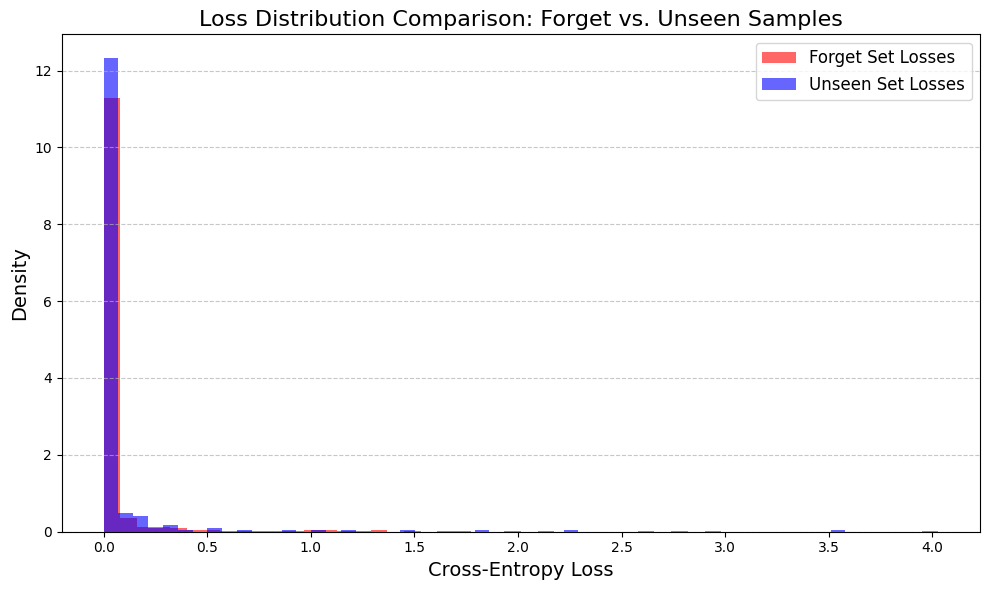

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DATA GENERATION (Re-calculate the required losses) ---
# NOTE: This assumes 'unlearned_model', 'forget_dataloader_test', and 'unseen_dataloader'
# are available in your environment.

print("Calculating losses for MIA plot...")
# Re-calculate losses on the unlearned model
# Ensure model is on CPU, as per previous debugging
unlearned_model_cpu = unlearned_model.to(torch.device('cpu'))

# compute_losses is defined to handle device placement, so pass the model
forget_losses = compute_losses(unlearned_model_cpu, forget_dataloader_test)
unseen_losses = compute_losses(unlearned_model_cpu, unseen_dataloader)

# NOTE: The MIA calculation only used the size of the smaller set, so we crop for a fair comparison,
#       but for visualization, plotting the full distribution is also informative.
#       We will plot the full calculated losses.

# --- 2. PLOTTING FUNCTION ---
def plot_mia_distribution(forget_losses, unseen_losses, save_path='mia_loss_distribution.png'):
    """Plots the distribution of losses for the forget and unseen sets."""

    plt.figure(figsize=(10, 6))

    # Plotting the density/distribution of losses
    plt.hist(
        forget_losses,
        bins=50,
        density=True,
        alpha=0.6,
        label='Forget Set Losses',
        color='red'
    )
    plt.hist(
        unseen_losses,
        bins=50,
        density=True,
        alpha=0.6,
        label='Unseen Set Losses',
        color='blue'
    )

    plt.title('Loss Distribution Comparison: Forget vs. Unseen Samples', fontsize=16)
    plt.xlabel('Cross-Entropy Loss', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a vertical line at the typical separation point (often where the density lines cross)
    # This separation is difficult to calculate automatically, so we'll just draw a hint.
    # Note: If distributions are heavily overlapped (like yours should be), this line is less useful.
    # plt.axvline(x=0.5, color='gray', linestyle='--')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"\nSaved MIA Distribution Plot to {save_path}")
    # plt.show() # NOTE: Remember to avoid plt.show() in the VM


# --- 3. EXECUTION ---
# Call the function with the calculated losses
plot_mia_distribution(forget_losses, unseen_losses)

# --- 4. OPTIONAL: Utility Bar Chart (if you have the original model's numbers) ---

# Replace these placeholders with your actual original model accuracy numbers
# Example: Original model had Test Acc 0.99 and Unseen Acc 0.98
ORIGINAL_TEST_ACC = 0.99
ORIGINAL_UNSEEN_ACC = 0.98

# Get the results from the unlearned model evaluation
UNLEARNED_TEST_ACC = test_acc['Acc']
UNLEARNED_UNSEEN_ACC = unseen_acc['Acc']

def plot_utility_comparison(original_test, original_unseen, unlearned_test, unlearned_unseen, save_path='utility_comparison.png'):
    """Plots the test and unseen accuracy for original vs unlearned models."""

    labels = ['Test (Retain) Accuracy', 'Unseen Accuracy']
    original_scores = [original_test, original_unseen]
    unlearned_scores = [unlearned_test, unlearned_unseen]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width/2, original_scores, width, label='Original Model', color='blue')
    rects2 = ax.bar(x + width/2, unlearned_scores, width, label='Unlearned Model', color='red')

    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_title('Accuracy Comparison: Original vs. Unlearned Model', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim([0.9, 1.0]) # Zoom in on the high accuracy range

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rects[0].get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=10)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"\nSaved Utility Comparison Plot to {save_path}")

# Execute the optional utility plot (use your own original scores!)
# plot_utility_comparison(ORIGINAL_TEST_ACC, ORIGINAL_UNSEEN_ACC, UNLEARNED_TEST_ACC, UNLEARNED_UNSEEN_ACC)

High Overlap (Success!): The red (Forget Set) and blue (Unseen Set) distributions are almost perfectly superimposed. This is the single most important indicator of successful unlearning.

Interpretation: The unlearned model treats samples it was supposed to forget the same way it treats genuinely new, unseen samples. The Membership Inference Attacker (MIA), who relies on distinguishing the loss pattern of the two groups, has almost no basis for distinction.

In [54]:
import os
import shutil

# Define the source file path (where Matplotlib saves it)
source_file = 'mia_loss_distribution.png'

# Define the destination directory (your project folder on Drive)
# Adjust this path if necessary!
destination_dir = '/content/drive/MyDrive/Machine_Unlearning_Project/data/'

if os.path.exists(source_file):
    shutil.move(source_file, destination_dir)
    print(f"✅ Successfully moved {source_file} to Google Drive.")
else:
    print(f"❌ Error: {source_file} not found in the current directory.")

✅ Successfully moved mia_loss_distribution.png to Google Drive.
